In [1]:
!pip install optbinning

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from optbinning import OptimalBinning

(CVXPY) Jan 27 06:20:15 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 27 06:20:15 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')


In [3]:
#Load the dataset
data = pd.read_csv('heart.csv')

In [4]:
print("Dataset Preview:")
display(data.head())

Dataset Preview:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [5]:
print("\nDataset Summary:")
display(data.info())


Dataset Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None

In [6]:
print("\nDataset Statistics:")
display(data.describe())


Dataset Statistics:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [7]:
target = 'target'

In [8]:
features = data.columns.drop(target)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], 
                                                    test_size=0.3, random_state=42)

In [10]:
# Optimal Binning
optimal_bins = {}
woe_train = pd.DataFrame(index=X_train.index)
woe_test = pd.DataFrame(index=X_test.index)

In [12]:
for feature in features:
    # Perform optimal binning
    binning = OptimalBinning(name=feature, dtype="numerical", solver="cp")
    binning.fit(X_train[feature], y_train)
    optimal_bins[feature] = binning

    # Transform features to WOE
    woe_train[feature] = binning.transform(X_train[feature], metric="woe")
    woe_test[feature] = binning.transform(X_test[feature], metric="woe")

In [13]:
# 3. Train Logistic Regression using WOE-transformed data
clf = LogisticRegression()
clf.fit(woe_train, y_train)

LogisticRegression()

In [14]:
# Make predictions
y_train_pred = clf.predict_proba(woe_train)[:, 1]
y_test_pred = clf.predict_proba(woe_test)[:, 1]

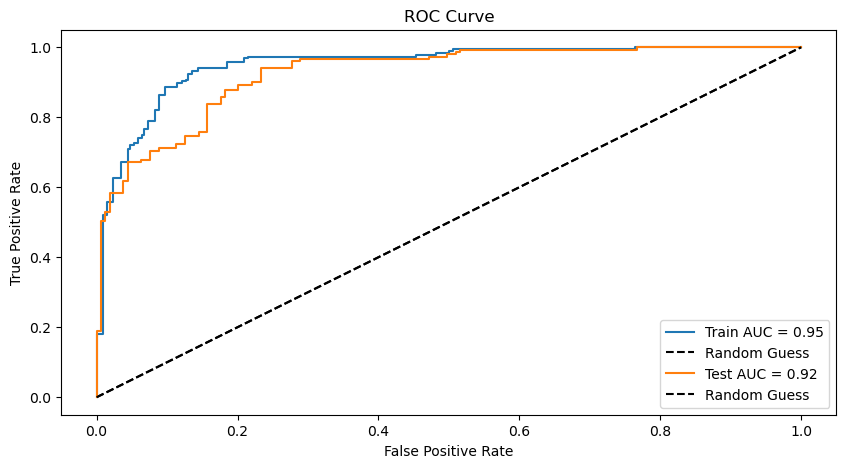

In [15]:
# 4. Calculate and Plot ROC Curve
def plot_roc(y_true, y_pred, dataset_type="Train"):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    plt.plot(fpr, tpr, label=f"{dataset_type} AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

plt.figure(figsize=(10, 5))
plot_roc(y_train, y_train_pred, dataset_type="Train")
plot_roc(y_test, y_test_pred, dataset_type="Test")
plt.show()

In [20]:
# Function to create WOE tables
def woe_table(binning, feature):
    binning_table = binning.binning_table.build()
    table = pd.DataFrame(binning_table)  # Convert the dictionary to a DataFrame
    table["Feature"] = feature  # Add the feature name
    return table


In [21]:
# Combine WOE tables for all features
woe_tables = pd.concat([woe_table(binning, feature) for feature, binning in optimal_bins.items()])


In [22]:
# Display WOE table
print("WOE Table:")
display(woe_tables)

WOE Table:


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Feature
0,"(-inf, 42.50)",93,0.129707,25,68,0.731183,-0.897332,0.095873,0.011598,age
1,"[42.50, 45.50)",63,0.087866,20,43,0.682540,-0.662168,0.036575,0.004490,age
2,"[45.50, 53.50)",143,0.199442,49,94,0.657343,-0.548175,0.057679,0.007121,age
3,"[53.50, 54.50)",42,0.058577,15,27,0.642857,-0.484487,0.013324,0.001649,age
4,"[54.50, 56.50)",42,0.058577,23,19,0.452381,0.294355,0.005077,0.000632,age
...,...,...,...,...,...,...,...,...,...,...
0,"(-inf, 2.50)",430,0.599721,115,315,0.732558,-0.904341,0.449736,0.054376,thal
1,"[2.50, inf)",287,0.400279,225,62,0.216028,1.392266,0.692385,0.080172,thal
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,thal
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000,thal


<Figure size 800x400 with 0 Axes>

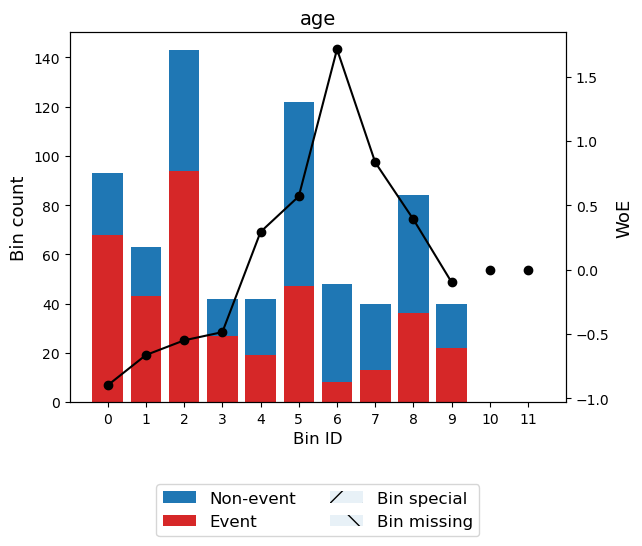

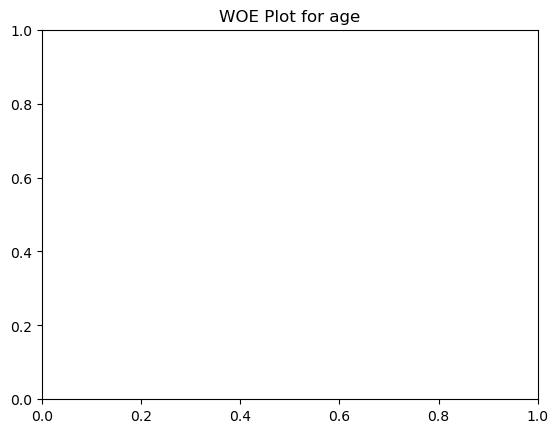

<Figure size 800x400 with 0 Axes>

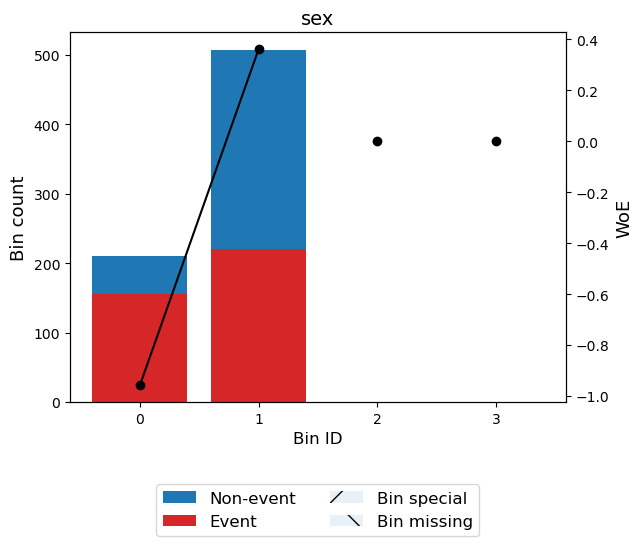

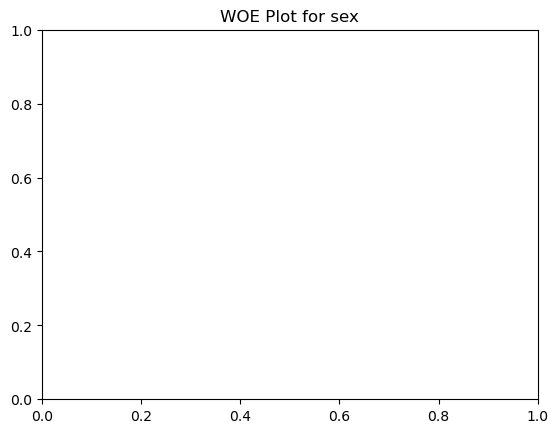

<Figure size 800x400 with 0 Axes>

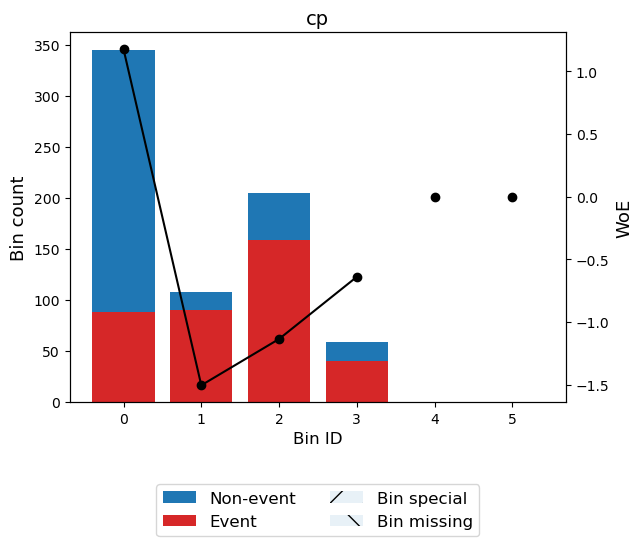

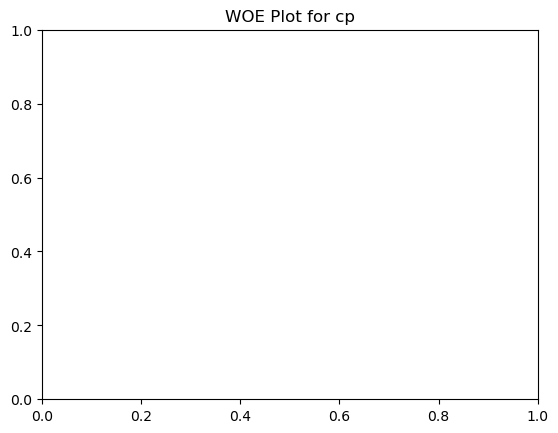

<Figure size 800x400 with 0 Axes>

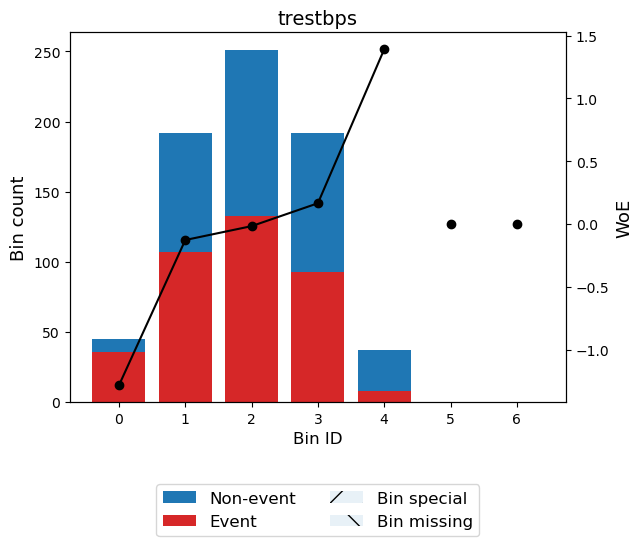

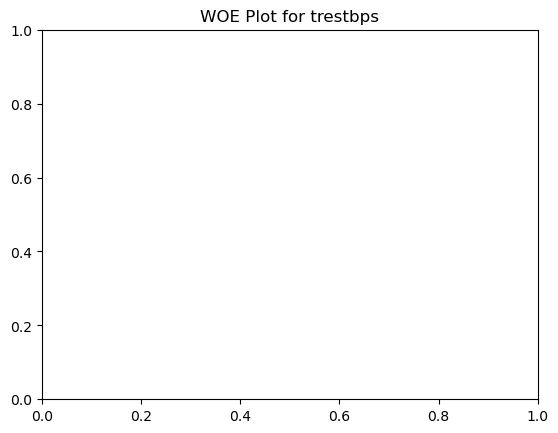

<Figure size 800x400 with 0 Axes>

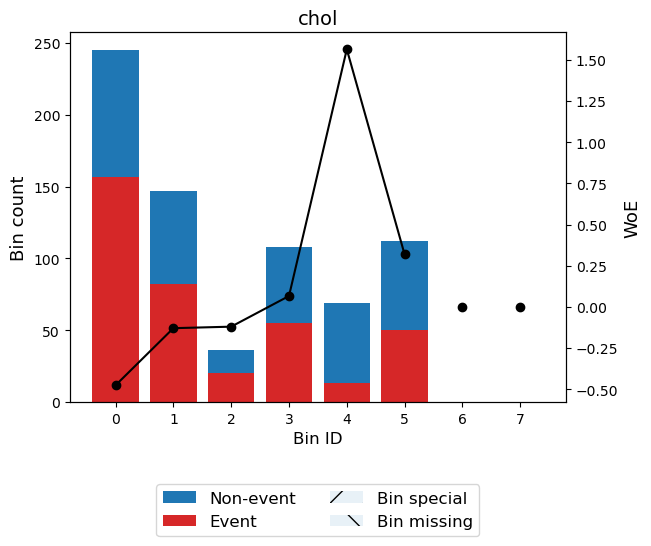

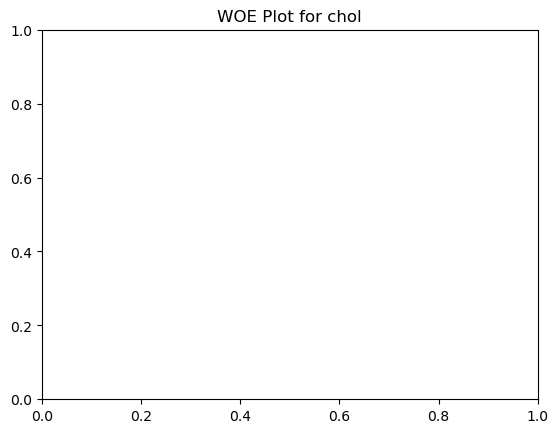

<Figure size 800x400 with 0 Axes>

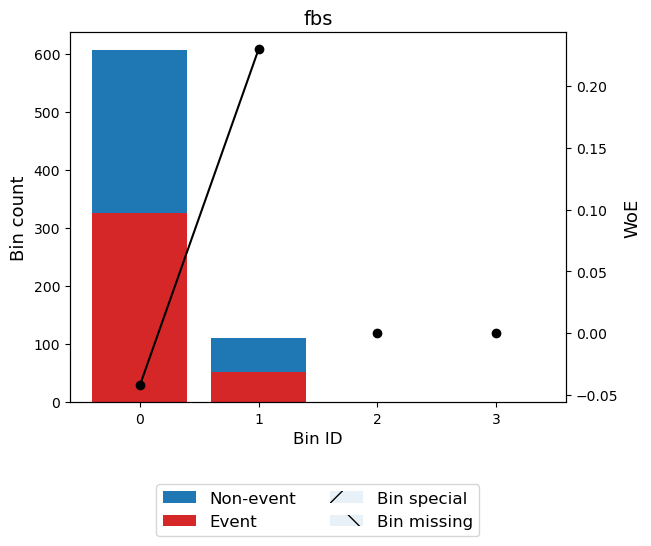

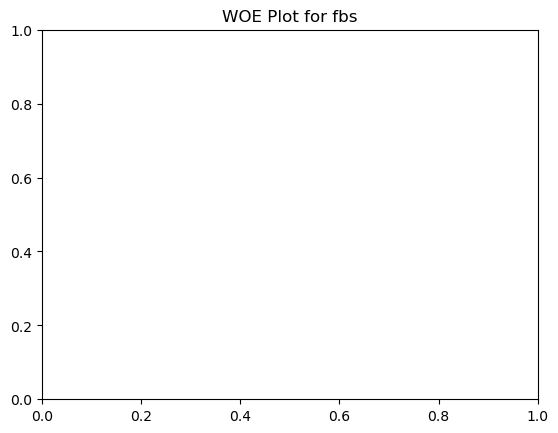

<Figure size 800x400 with 0 Axes>

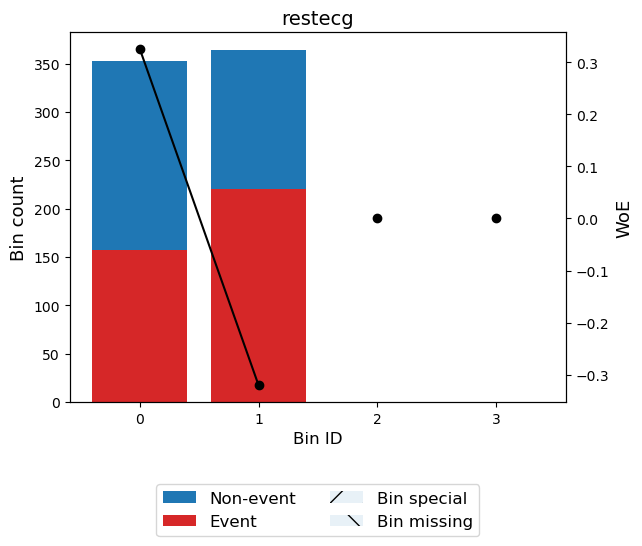

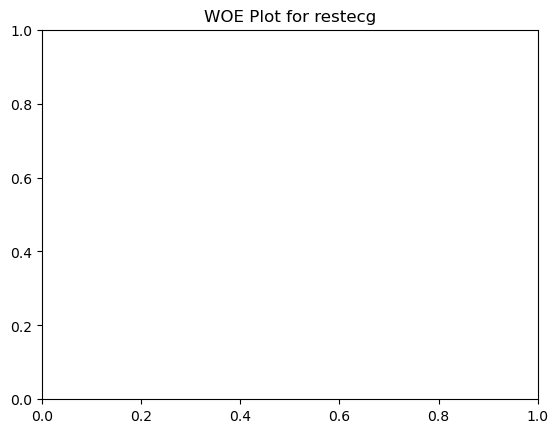

<Figure size 800x400 with 0 Axes>

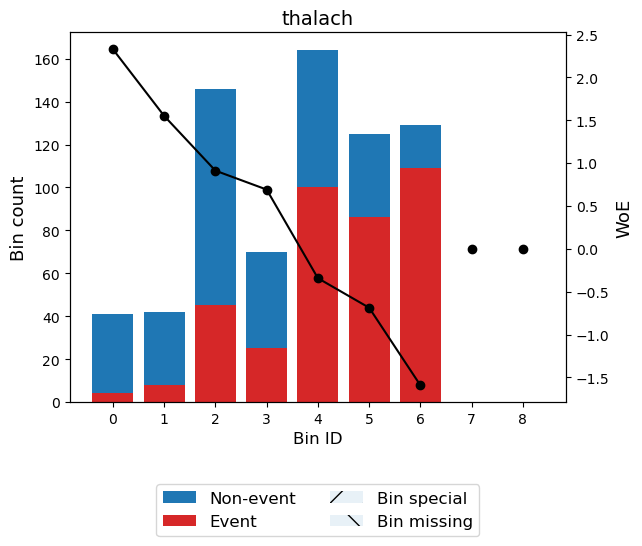

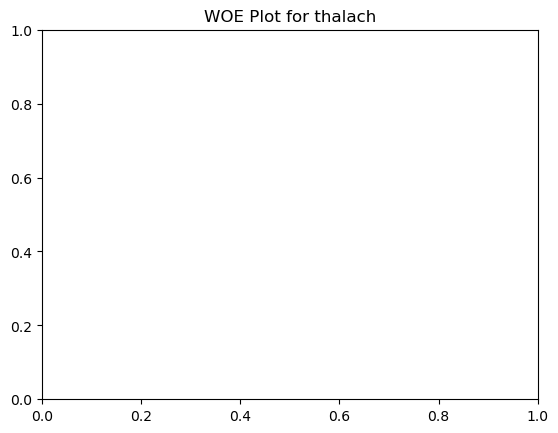

<Figure size 800x400 with 0 Axes>

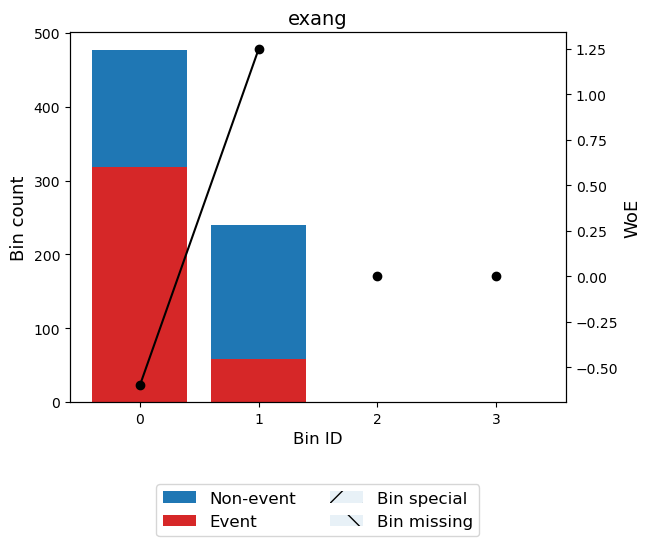

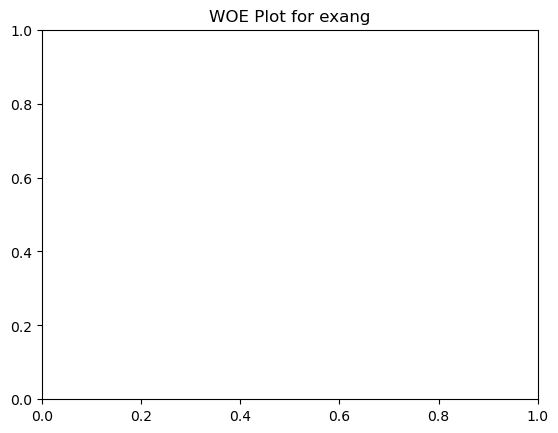

<Figure size 800x400 with 0 Axes>

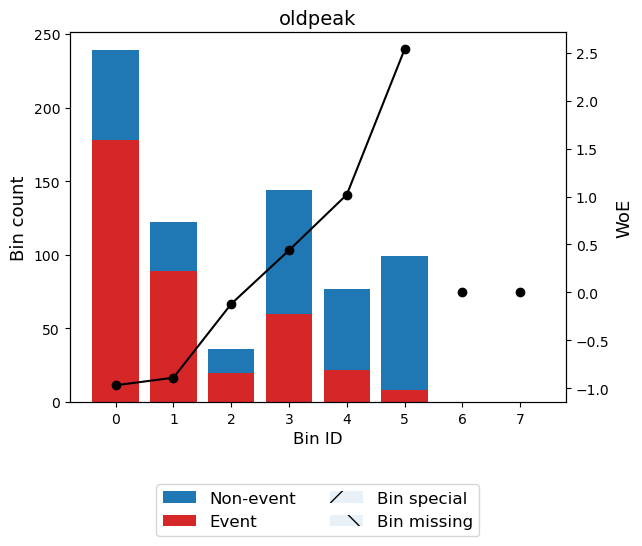

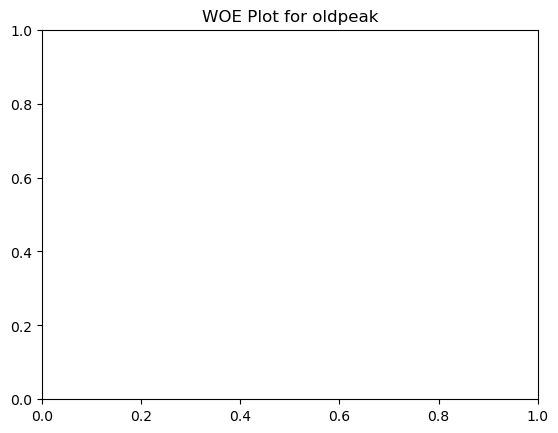

<Figure size 800x400 with 0 Axes>

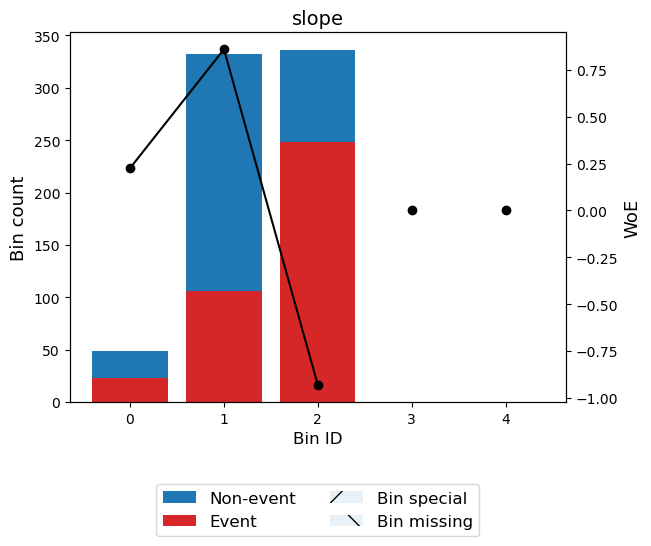

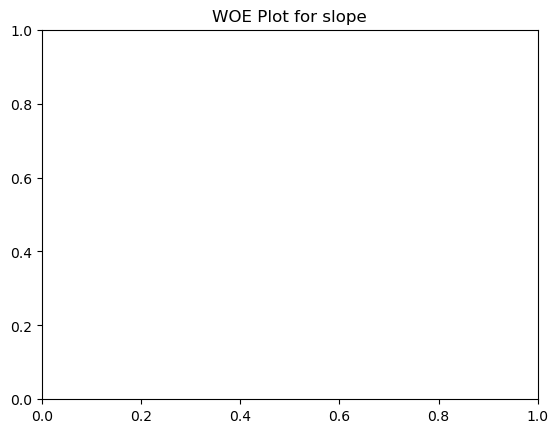

<Figure size 800x400 with 0 Axes>

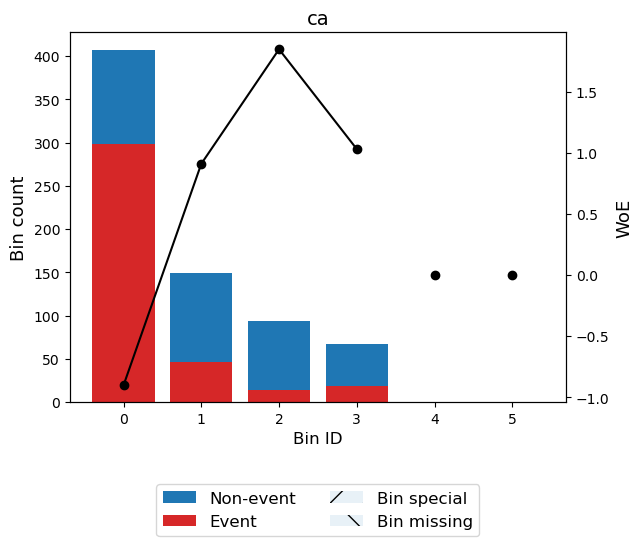

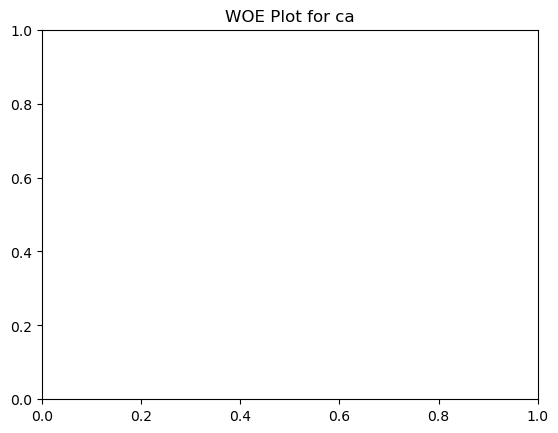

<Figure size 800x400 with 0 Axes>

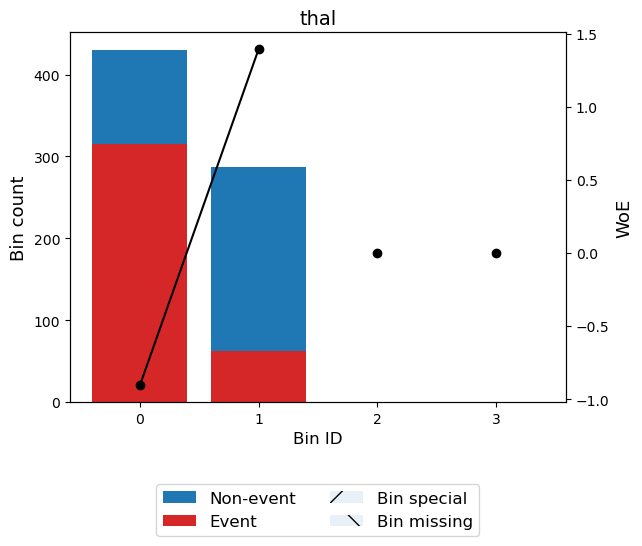

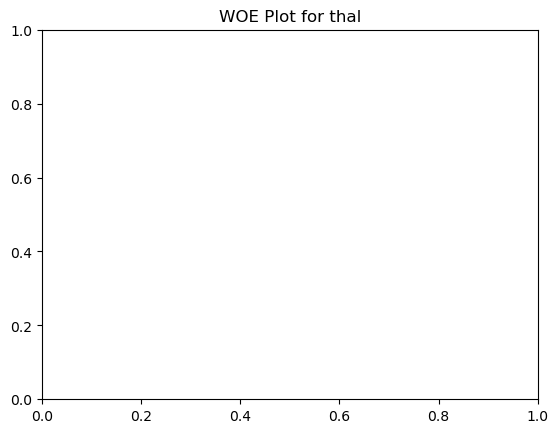

In [23]:
# Visualize WOE Binning
for feature, binning in optimal_bins.items():
    plt.figure(figsize=(8, 4))
    binning.binning_table.plot(metric="woe")
    plt.title(f"WOE Plot for {feature}")
    plt.show()